In [1]:
import colour_scheme as cs
import importlib
importlib.reload(cs)

import scanpy as sc
sc.settings.set_figure_params(dpi=100, fontsize=10, dpi_save=250, format='pdf')
import numpy as np
import pandas as pd
from scipy import io
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
from pathlib import Path
%matplotlib inline

path_fig = ''
sc.settings.figdir = path_fig
sc.settings.set_figure_params(dpi=100, fontsize=10, dpi_save=350, format='.png')
path_data = ''

# Read file

In [2]:
adata = sc.read_h5ad(Path(path_data)/'OSMGT_v1.h5ad')
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca = pca.fit_transform(adata.obsm['rss'])
adata.obsm['rss_pca'] = pca
adata

AnnData object with n_obs × n_vars = 100538 × 33421
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'Condition', 'Morphogen', 'Morphogen_AP', 'Dose_AP', 'Timing', 'Morphogen_DV', 'Dose_DV', 'Timing_DV', 'Morphogen_F', 'Dose_F', 'Timing_F', 'Cell_Line', 'Timing_AP', 'BEST', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.1', 'seurat_clusters', 'nCount_exon', 'nFeature_exon', 'nCount_intron', 'nFeature_intron', 'maxsim_linnarsson', 'maxsim_mmgastrul', 'maxsim_fleck', 'css_normdist_fleck', 'css_faillh_fleck', 'maxsim_region', 'cssproj_region', 'seurat_cluster_annotation', 'merged_cluster_annotation', 'Germ_Layer', 'Experiment', 'Condition_raw', 'Cell_Line_raw', 'Condition_ident', 'Condition_ident_line', 'best_class', 'best_score_class', 'best_region', 'best_NT', 'best_score_NT'
    var: 'features'

In [3]:
metadata = pd.read_csv(Path(path_data)/"meta_OSMGT.tsv", sep='\t')
adata.obs['Cell_Line'] = metadata.Cell_Line

# Centroids-based interaction analysis

## NNLS

In [6]:
import scipy


1.14.1


In [94]:
inter = adata[adata.obs.Experiment.isin(['OG1', 'OG2'])].copy()
inter = inter[inter.obs.Cell_Line == 'WTC'].copy() ## CHOOSE CELL LINE
centroids = pd.DataFrame(inter.obsm[ 'rss_pca']).copy()
centroids['Condition'] = inter.obs['Condition'].values.tolist().copy()
centroids['Condition'] = centroids['Condition'].replace({'Control_OG2': 'Control', 'Control_OG1': 'Control'})
centroids = centroids.groupby('Condition').mean()

conditions = [ ['XAV939_A','SHH_A', 'XAV939_A_SHH_A'],
              ['XAV939_E', 'SHH_A', 'XAV939_E_SHH_A'],
              ['XAV939_A', 'SHH_E','XAV939_A_SHH_E'],
              [  'XAV939_E', 'SHH_E', 'XAV939_E_SHH_E'],
                ['XAV939_A','CycA_E', 'XAV939_A_CycA_E']  ,      
              ['XAV939_E', 'CycA_E','XAV939_E_CycA_E'],

              ['RA_E', 'SHH_A','RA_E_SHH_A'],
              ['RA_E',  'SHH_E','RA_E_SHH_E'],
              ['RA_E','CycA_E','RA_E_CycA_E'],

              ['CHIR_E','CycA_E','CHIR_E_CycA_E'],
              ['CHIR_E','SHH_A','CHIR_E_SHH_A'],
               ['CHIR_E','SHH_E','CHIR_E_SHH_E']
             ]

In [95]:
from scipy.optimize import nnls
def residuals_calculation_control(centroids, cond_set):
    centroids_small = centroids.loc[cond_set, :].copy() - centroids.loc['Control', :]
    
    A = np.column_stack((centroids_small.iloc[0,:], centroids_small.iloc[1,:]))

    coefficients, residuals = nnls(A, centroids_small.iloc[2,:])

    return residuals
                         


In [96]:
result = {}              
for elem in conditions:
    result[elem[2]] = [residuals_calculation_control(centroids, elem)]

result = pd.DataFrame(result)
result = result.T
result.sort_values(by=0)


,0
XAV939_A_CycA_E,0.666478
XAV939_A_SHH_A,0.673837
CHIR_E_SHH_A,0.710277
XAV939_E_CycA_E,0.900399
RA_E_CycA_E,1.027873
RA_E_SHH_A,1.054394
CHIR_E_SHH_E,1.600619
RA_E_SHH_E,1.605412
CHIR_E_CycA_E,1.650142
XAV939_E_SHH_A,1.653354


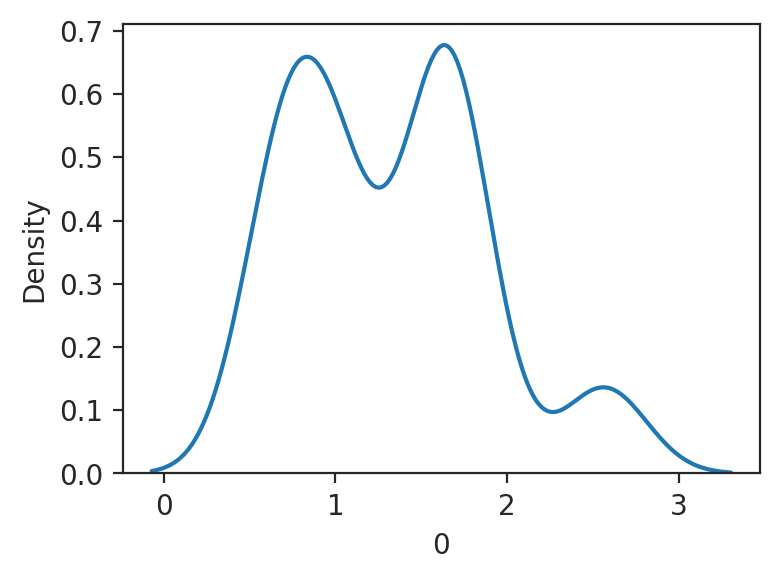

In [97]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.kdeplot(data=result, x=0,bw_adjust=0.7)


plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 


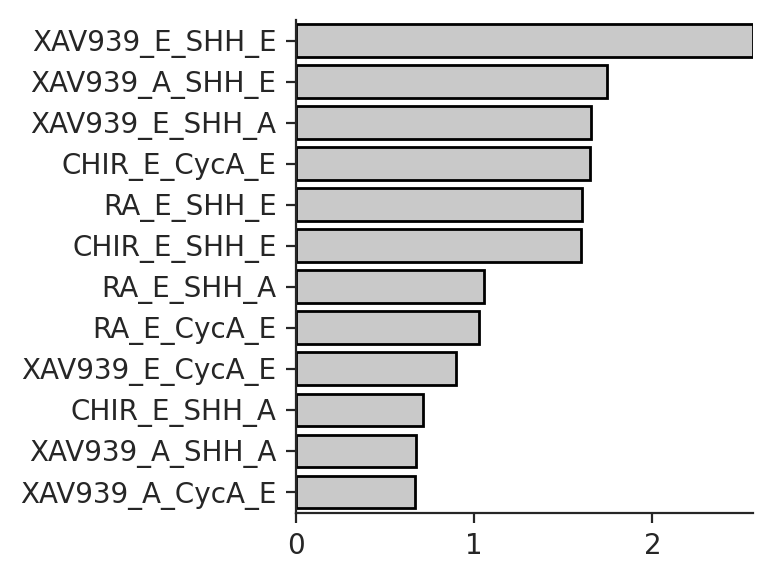

In [98]:
### Fig 3e ###

result = result.sort_values(by=0, ascending=False)

fig, ax = plt.subplots(figsize=(4, 3))


sns.set_style("white")
sns.set_style('ticks') 
ax.spines[['right', 'top']].set_visible(False)

sns.barplot(y=result.index, x=result[0],
    linewidth=1, edgecolor="black", facecolor='#C9C9C9')
#plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('')
ax.set(xlim=(0, max(result[0])))

plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.savefig(path_fig+'/interactions/residuals_barplot_WTC.pdf', dpi=500, 
           format='pdf', bbox_inches='tight')

plt.show()

In [38]:
result

,0
XAV939_A_CycA_E,0.666478
XAV939_A_SHH_A,0.673837
CHIR_E_SHH_A,0.710277
XAV939_E_CycA_E,0.900399
RA_E_CycA_E,1.027873
RA_E_SHH_A,1.054394
CHIR_E_SHH_E,1.600619
RA_E_SHH_E,1.605412
CHIR_E_CycA_E,1.650142
XAV939_E_SHH_A,1.653354


# Distance to FGF8

In [80]:
df = pd.read_csv(Path(path_data)/'mmd_general_OSMGT_self_pca.tsv',
                 sep='\t', index_col='cell_condition')

df = df.loc[df.columns[df.columns.str.contains('HES3')].tolist(),df.columns[df.columns.str.contains('HES3')].tolist()].copy()
df.columns = df.columns.str.replace('HES3_', '', regex=False)

df.index = df.index.str.replace('HES3_', '', regex=False)

In [81]:
cond_fgf = [['XAV939_E_CycA_E_FGF8_A', 'XAV939_E_CycA_E'],
            ['RA_E_CycA_E_FGF8_A', 'RA_E_CycA_E'],
            ['RA_E_FGF8_A', 'RA_E'],
            ['XAV939_E_SHH_A_FGF8_A','XAV939_E_SHH_A'],
            ['XAV939_E_FGF8_A','XAV939_E'],
            [ 'RA_E_SHH_A_FGF8_A',  'RA_E_SHH_A']]
            


In [82]:
result = {}
for elem in cond_fgf:
    A = df.loc[elem[0], elem[1]]
   
    result[elem[1]] = [A]

result = pd.DataFrame(result).T
result.sort_values(by=0, ascending = False)

,0
XAV939_E,20.891430
XAV939_E_CycA_E,17.136492
RA_E,9.435255
XAV939_E_SHH_A,3.190428
RA_E_SHH_A,2.158332
RA_E_CycA_E,1.303614


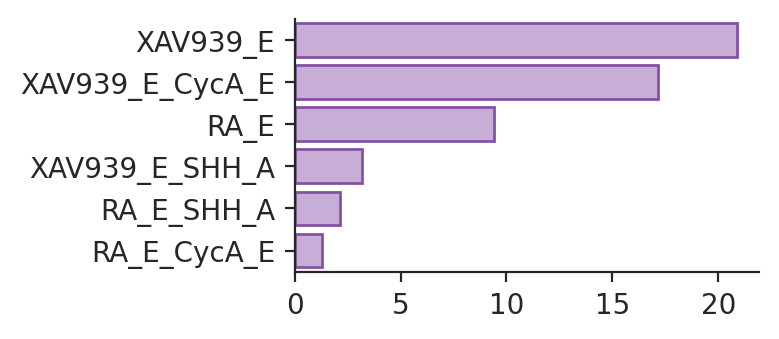

In [84]:
### Fig 3c ###

result = result.sort_values(by=0, ascending=False)

fig, ax = plt.subplots(figsize=(4, 1.8))


sns.set_style("white")
sns.set_style('ticks') 
ax.spines[['right', 'top']].set_visible(False)

sns.barplot(y=result.index, x=result[0],
    linewidth=1, edgecolor="#8452A3", facecolor='#C7AED6')
#plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('')
ax.set(xlim=(0, max(result[0])*1.05))

plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.savefig(path_fig+'/interactions/distance_to_fgf_HES3.pdf', dpi=500, 
            format='pdf', bbox_inches='tight')

plt.show()